**MULTI CLASSIFICATION WITH PYTORCH**

*DATASETS : CS231N from https://cs231n.github.io/neural-networks-case-study/*

1. Import library

In [29]:
! pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torchmetrics as tm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

2. Creating data CS231N from https://cs231n.github.io/neural-networks-case-study/

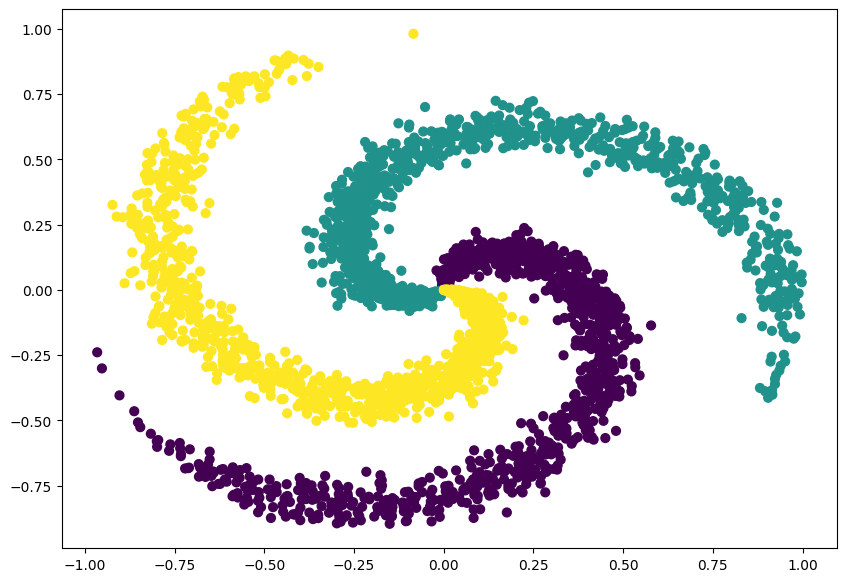

In [31]:
N = 1000 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data:
plt.figure(figsize=(10,7))
plt.scatter(X[:, 0], X[:, 1], c=y, s=40)
plt.show()

In [32]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
x_train.shape,y_train.shape,x_test.shape,y_test.shape

(torch.Size([2400, 2]),
 torch.Size([2400]),
 torch.Size([600, 2]),
 torch.Size([600]))

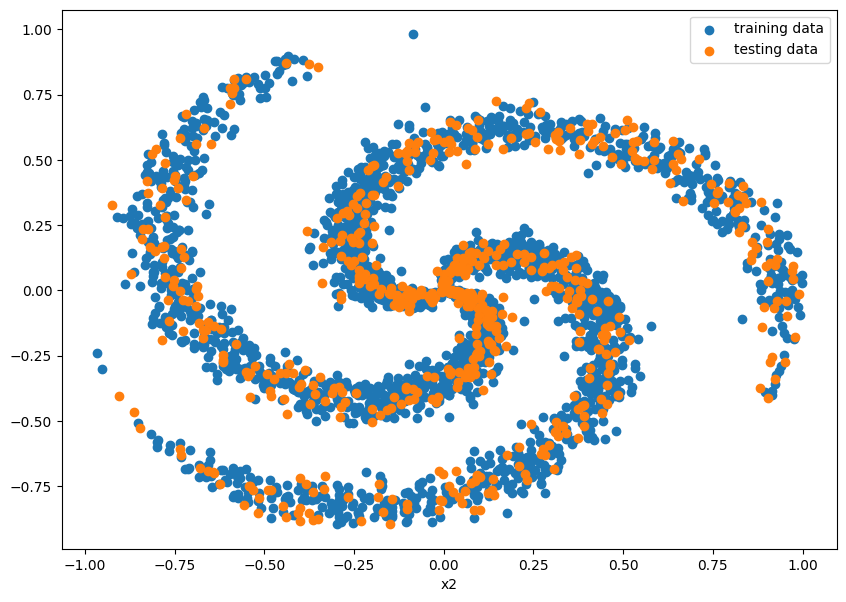

In [33]:
plt.figure(figsize=(10,7))

plt.scatter(x_train[:,0],x_train[:,1],label="training data")
plt.scatter(x_test[:,0],x_test[:,1],label="testing data")
plt.xlabel("x1")
plt.xlabel("x2")
plt.legend()
plt.show()

3. Build model

In [34]:
class MultiClassificationModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(in_features=2,out_features=8)
        self.linear2 = nn.Linear(in_features=8,out_features=8)
        self.linear3 = nn.Linear(in_features=8,out_features=3)
        self.relu = nn.ReLU()

    def forward(self,x:torch.Tensor) -> torch.Tensor :
        layer1 = self.linear1(x)
        layer2 = self.linear2(self.relu(layer1))
        layer3 = self.linear3(self.relu(layer2))
        return layer3

In [35]:
model = MultiClassificationModelV0()
print(model)

MultiClassificationModelV0(
  (linear1): Linear(in_features=2, out_features=8, bias=True)
  (linear2): Linear(in_features=8, out_features=8, bias=True)
  (linear3): Linear(in_features=8, out_features=3, bias=True)
  (relu): ReLU()
)


In [36]:
model.eval()
with torch.inference_mode():
    y_pred_test = model(x_test)
    y_pred_label = torch.argmax(torch.softmax(y_pred_test,dim=1),dim=1)
    print(y_pred_label[:10])
    print(y_test[:10])

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([2, 0, 0, 1, 0, 2, 1, 0, 0, 2])


In [37]:
lossCross = nn.CrossEntropyLoss()
opt = torch.optim.SGD(params=model.parameters(),lr=0.08)

In [38]:
EPOCHS = 3000
epoch_list = []
loss_train_list = []
loss_test_list = []
acc_train_list = []
acc_test_list = []
multi_acc = tm.Accuracy(task="multiclass", num_classes=3)

for epoch in range(EPOCHS):
    # training
    model.train()

    y_pred_train = model(x_train)
    loss_train = lossCross(y_pred_train,y_train)

    y_pred_label_train = torch.argmax(torch.softmax(y_pred_train,dim=1),dim=1)
    acc_train = multi_acc(y_pred_label_train,y_train)

    opt.zero_grad()
    loss_train.backward()
    opt.step()

    # evaluting
    model.eval()
    with torch.inference_mode():
        y_pred_test = model(x_test).type(torch.float)
        loss_test = lossCross(y_pred_test,y_test)

        y_pred_label_test = torch.argmax(torch.softmax(y_pred_test,dim=1),dim=1)
        acc_test = multi_acc(y_pred_label_test,y_test)

        if epoch % 150 == 0:
            print(f"Epoch {epoch}#")
            print(f"Loss train : {loss_train}, Accuracy train : {acc_train}%")
            print(f"Loss test : {loss_test}, Accuracy test : {acc_test}%")

            epoch_list.append(epoch)
            loss_train_list.append(loss_train.detach().numpy())
            loss_test_list.append(loss_test.detach().numpy())
            acc_train_list.append(acc_train)
            acc_test_list.append(acc_test)

Epoch 0#
Loss train : 1.1223218441009521, Accuracy train : 0.335833340883255%
Loss test : 1.1259593963623047, Accuracy test : 0.3233333230018616%
Epoch 150#
Loss train : 1.0738776922225952, Accuracy train : 0.5420833230018616%
Loss test : 1.0735386610031128, Accuracy test : 0.5400000214576721%
Epoch 300#
Loss train : 0.907686173915863, Accuracy train : 0.5820833444595337%
Loss test : 0.9001330733299255, Accuracy test : 0.5716666579246521%
Epoch 450#
Loss train : 0.7060592770576477, Accuracy train : 0.5841666460037231%
Loss test : 0.7060253024101257, Accuracy test : 0.5899999737739563%
Epoch 600#
Loss train : 0.6213514804840088, Accuracy train : 0.6320833563804626%
Loss test : 0.6304843425750732, Accuracy test : 0.6266666650772095%
Epoch 750#
Loss train : 0.5429294109344482, Accuracy train : 0.7024999856948853%
Loss test : 0.55707186460495, Accuracy test : 0.6783333420753479%
Epoch 900#
Loss train : 0.4909648597240448, Accuracy train : 0.7283333539962769%
Loss test : 0.5088513493537903,

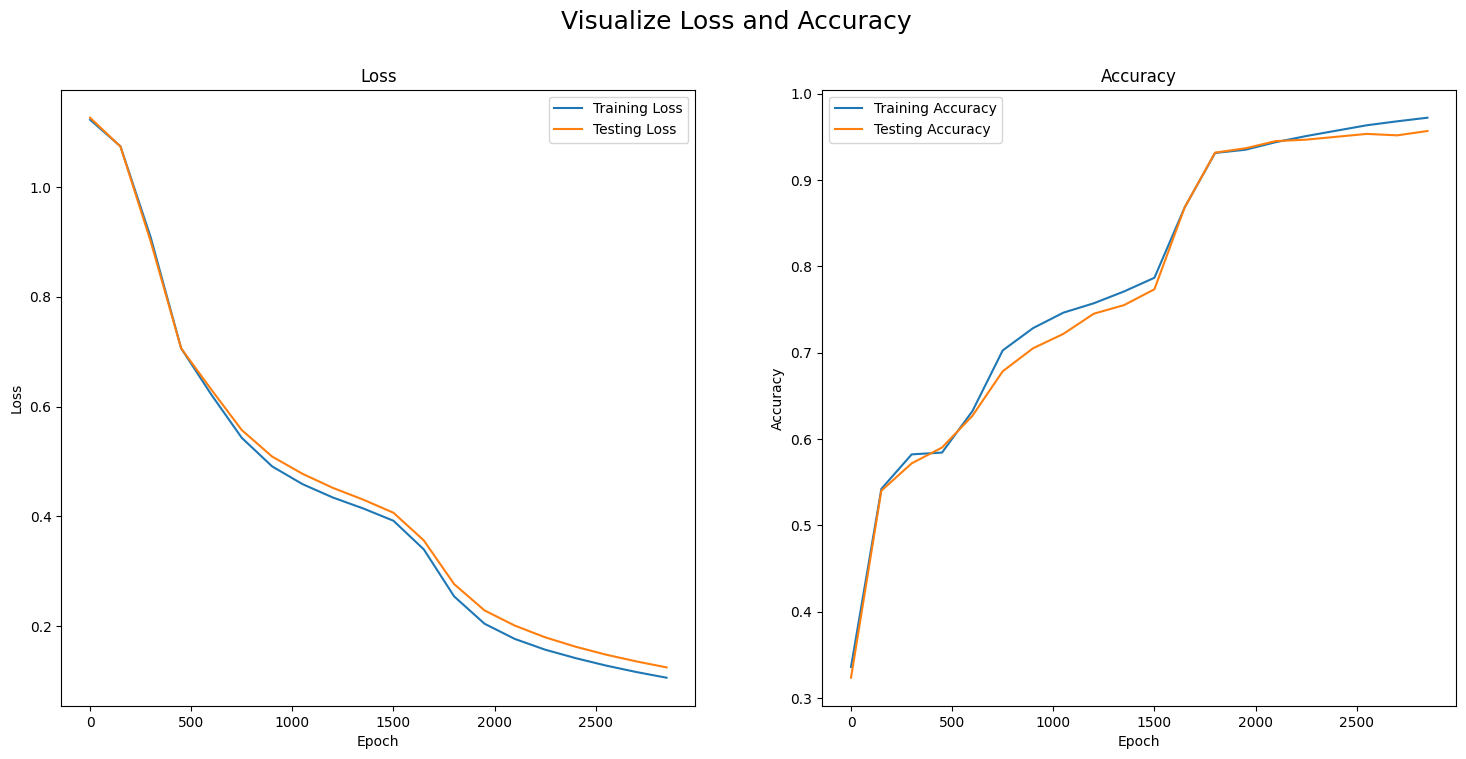

In [39]:
plt.figure(figsize=(18,8))
plt.suptitle("Visualize Loss and Accuracy", fontsize=18)

plt.subplot(1,2,1)
plt.plot(epoch_list,loss_train_list,label="Training Loss")
plt.plot(epoch_list,loss_test_list,label="Testing Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epoch_list,acc_train_list,label="Training Accuracy")
plt.plot(epoch_list,acc_test_list,label="Testing Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

helper_functions.py already exists, skipping download


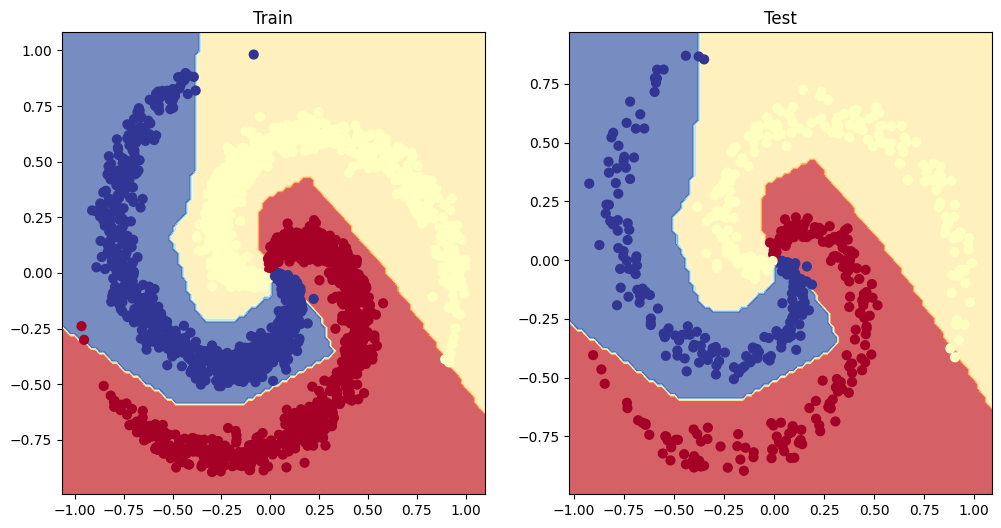

In [40]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, x_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, x_test, y_test)

In [41]:
model.eval()
with torch.inference_mode():
    y_pred_test = model(x_test)
    y_pred_label = torch.argmax(torch.softmax(y_pred_test,dim=1),dim=1)
    print("Confusion Matrix")
    confusion_matrix = tm.ConfusionMatrix(task="multiclass", num_classes=3)
    print(confusion_matrix(y_pred_label, y_test))
    print("-"*20)
    print(y_pred_label[:10])
    print(y_test[:10])

Confusion Matrix
tensor([[183,   0,  11],
        [  2, 202,   2],
        [  8,   2, 190]])
--------------------
tensor([2, 0, 2, 1, 0, 2, 1, 0, 0, 2])
tensor([2, 0, 0, 1, 0, 2, 1, 0, 0, 2])


In [42]:
from pathlib import Path 

MODEL = Path("model")
MODEL.mkdir(parents=True,exist_ok=True)
MODEL_NAME= "CS231N_multi_classification_model.pth"
MODEL_PATH = MODEL / MODEL_NAME

torch.save(obj=model.state_dict(),f=MODEL_PATH)